In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [16]:
variable_info = [
    # Firm Variables
    Variable(name="Y", dims="i", description="Total output of good <dim:i>"),
    Variable(name="VA", dims="i", description="Labor-capital bundle produced by sector <dim:i>"),
    Variable(
        name="VC", dims="i", description="Intermediate goods bundle produced by sector <dim:i>"
    ),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for sector <dim:i> goods by sector <dim:j>",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demanded by sector <dim:i>",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demanded by sector <dim:i>",
    ),
    # Household Variables
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of good <dim:i>"),
    Variable(name="income", latex_name="Omega", description="Total household income"),
    # Prices
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the labor-capital bundle in sector <dim:i>",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate bundle in sector <dim:i>",
    ),
    Variable(name="P", dims="i", description="Price level of final goods in sector <dim:i>"),
    # Other
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    # Firm Parameters
    Parameter(
        name="psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of labor-capital in sector <dim:i>'s final good",
    ),
    Parameter(
        name="psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of intermediate goods bundle in sector <dim:i>'s final product",
    ),
    Parameter(
        name="psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of sector <dim:i>'s final good in sector <dim:j>'s value chain bundle",
    ),
    Parameter(
        name="alpha",
        dims="i",
        description="Share of capital in sector <dim:i>'s production process",
    ),
    Parameter(name="A", dims="i", description="Total factor productivity in sector <dim:i>"),
    # Household Parameters
    Parameter(
        name="gamma",
        dims="i",
        description="Household utility weight on consumption of sector <dim:i> goods",
    ),
    # Exogenous variables
    Parameter(name="L_s", description="Exogenous household labor supply"),
    Parameter(name="K_s", description="Exogenous household capital stock"),
    Parameter(
        name="P_Ag_bar",
        latex_name=r"\bar{P}_{Ag}",
        description="Exogenous agricultural price level",
    ),
]

equations = [
    # # Firm Equations
    # Final Goods
    Equation("Final good production of sector <dim:i>", "P * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC[None] * P_VC[None] = (P[:, None] * X).sum(axis=0).ravel()",
    ),
    Equation("Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC[None]"),
    # Value add bundle
    Equation(
        "Sector <dim:i> production of labor-capital",
        "VA = A * K_d ** alpha * L_d ** (1 - alpha)",
    ),
    Equation("Sector <dim:i> demand for capital", "K_d = alpha * VA * P / r"),
    Equation(
        "Sector <dim:i> demand for labor",
        "L_d = (1 - alpha) * VA * P / w",
    ),
    # # Household Equations
    Equation("Household income", "income = w * L_s + r * K_s"),
    Equation("Household utility", "U = (C**gamma).prod()"),
    Equation("Household demand for good <dim:i>", "C = gamma * income / P"),
    # # Market clearning conditions
    Equation("Labor market clearing", "L_s = L_d.sum() - resid"),
    Equation("Capital market clearing", "K_s = K_d.sum()"),
    Equation("Sector <dim:i> goods market clearing", "Y = C + X.sum(axis=1)"),
    Equation("Numeraire", "P[0] = P_Ag_bar"),
]

In [17]:
sectors = ["Ag", "Ind", "Serv"]

n_sectors = len(sectors)
coords = {"i": sectors, "j": sectors}

mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=False,
    backend="pytensor",
    mode="JAX",
)

In [18]:
data = np.array(
    [
        [0, 0, 0, 1000, 2000, 4000],
        [0, 0, 0, 500, 2000, 500],
        [7000, 3000, 0, 0, 0, 0],
        [0, 0, 2000, 1000, 1000, 1000],
        [0, 0, 2500, 2000, 3500, 3000],
        [0, 0, 5500, 500, 2500, 1000],
    ]
)

cols = ["L_d", "K_d", "Men", "Ag", "Ind", "Serv"]
df = pd.DataFrame(data, columns=cols, index=cols, dtype="float64")

In [19]:
data = {
    "L_d": df.loc["L_d", sectors].values,
    "K_d": df.loc["K_d", sectors].values,
    "X": df.loc[sectors, sectors].values,
    "Y": df.loc[sectors, :].values.sum(axis=1),
    "P": np.ones((n_sectors,)),
    "P_VA": np.ones((n_sectors,)),
    "P_VC": np.ones((n_sectors,)),
    "r": 1.0,
    "w": 1.0,
    "P_Ag_bar": 1.0,
}

In [20]:
def calibrate_model(L_d, K_d, Y, X, P, P_VA, P_VC, r, w, P_Ag_bar):
    calib_dict = {
        "L_d": L_d,
        "K_d": K_d,
        "Y": Y,
        "X": X,
        "P": P,
        "r": r,
        "w": w,
        "P_VA": P_VA,
        "P_VC": P_VC,
        "P_Ag_bar": P_Ag_bar,
    }

    # Numeraire
    resid = 0.0

    # Household calibration
    L_s = L_d.sum()
    K_s = K_d.sum()
    income = w * L_s + r * K_s
    C = Y - X.sum(axis=1)
    gamma = C / income * P
    U = (C**gamma).prod()

    # Firm calibration
    VA = (w * L_d + r * K_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha = r * K_d / VA / P
    A = VA / K_d**alpha / L_d ** (1 - alpha)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    calib_dict["VA"] = VA
    calib_dict["VC"] = VC
    calib_dict["psi_VC"] = psi_VC
    calib_dict["psi_VA"] = psi_VA
    calib_dict["psi_X"] = psi_X
    calib_dict["alpha"] = alpha
    calib_dict["A"] = A

    calib_dict["income"] = income
    calib_dict["C"] = C
    calib_dict["U"] = U
    calib_dict["gamma"] = gamma

    calib_dict["K_s"] = K_s
    calib_dict["L_s"] = L_s
    calib_dict["resid"] = resid
    calib_dict["w"] = w

    return calib_dict

In [27]:
calibrated_data

{'L_d': array([1000., 2000., 4000.]),
 'K_d': array([ 500., 2000.,  500.]),
 'Y': array([ 5000., 11000.,  9500.]),
 'X': array([[1000., 1000., 1000.],
        [2000., 3500., 3000.],
        [ 500., 2500., 1000.]]),
 'P': array([1., 1., 1.]),
 'r': 1.0,
 'w': 1.0,
 'P_VA': array([1., 1., 1.]),
 'P_VC': array([1., 1., 1.]),
 'P_Ag_bar': 1.0,
 'VA': array([1500., 4000., 4500.]),
 'VC': array([3500., 7000., 5000.]),
 'psi_VC': array([0.7       , 0.63636364, 0.52631579]),
 'psi_VA': array([0.3       , 0.36363636, 0.47368421]),
 'psi_X': array([[0.28571429, 0.14285714, 0.2       ],
        [0.57142857, 0.5       , 0.6       ],
        [0.14285714, 0.35714286, 0.2       ]]),
 'alpha': array([0.33333333, 0.5       , 0.11111111]),
 'A': array([1.88988157, 2.        , 1.41741118]),
 'income': 10000.0,
 'C': array([2000., 2500., 5500.]),
 'U': 3688.8456229964577,
 'gamma': array([0.2 , 0.25, 0.55]),
 'K_s': 3000.0,
 'L_s': 7000.0,
 'resid': 0.0}

In [21]:
calibrated_data = calibrate_model(**data)
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [22]:
from cge_modeling.base.utilities import variable_dict_to_flat_array, flat_array_to_variable_dict

labor_increase = calibrated_data.copy()
labor_increase["L_s"] = 10_000

_, theta_labor_increase = variable_dict_to_flat_array(labor_increase, mod.variables, mod.parameters)

In [23]:
n_steps = 10_000
idata = mod._solve_with_euler_approximation(
    calibrated_data, theta_final=theta_labor_increase, n_steps=n_steps
)

In [24]:
res = mod._solve_with_minimize(
    calibrated_data, theta_final=theta_labor_increase, method="trust-exact"
)
res_dict = flat_array_to_variable_dict(
    np.r_[res.x, theta_labor_increase], mod.variables + mod.parameters, mod.coords
)

In [25]:
mod.check_for_equilibrium(res_dict)

Equilibrium found! Total squared error: 0.000000


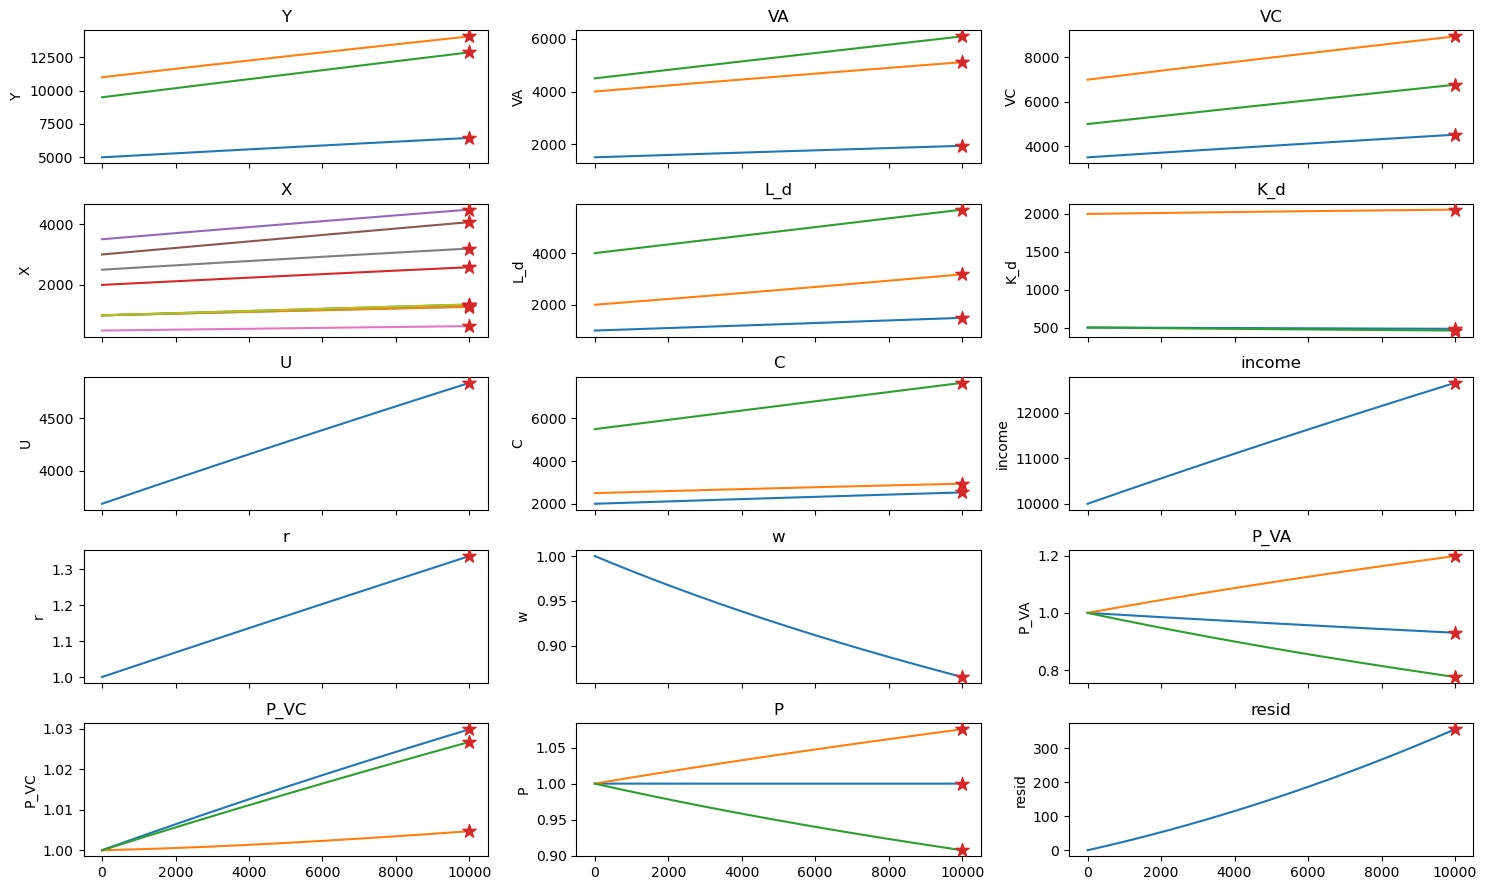

In [26]:
fig, ax = plt.subplots(5, 3, figsize=(15, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    data = idata.variables[var]
    if data.ndim > 2:
        data = data.stack(pair=["i", "j"])
    data.plot.line(x="step", ax=axis, add_legend=False)
    axis.set(title=var, xlabel=None)
    scatter_grid = np.full(int(np.prod(res_dict[var].shape)), idata.variables.coords["step"].max())
    axis.scatter(scatter_grid, res_dict[var].ravel(), marker="*", color="tab:red", zorder=10, s=100)
fig.tight_layout()